# Predicting Heart Disease

Link to Competittion: https://www.kaggle.com/competitions/playground-series-s6e2/overview

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12, 6)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.cluster import KMeans

from common import *

In [2]:
from platform import python_version
print('python: ', python_version())
print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
import sklearn
print('sklearn: ', sklearn.__version__)
print('xgboost: ', xgb.__version__)

python:  3.13.11
pandas:  2.3.3
numpy:  2.3.5
matplotlib:  3.10.8
seaborn:  0.13.2
sklearn:  1.8.0
xgboost:  3.1.3


## Helpers

## Load data

In [3]:
train_df = pd.read_csv('archive/train.csv')
test_df = pd.read_csv('archive/test.csv')

In [4]:
train_df

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,629995,56,0,1,110,226,0,0,132,0,0.0,1,0,7,Absence
629996,629996,54,1,4,128,249,1,2,150,0,0.0,2,0,3,Absence
629997,629997,67,1,4,130,275,0,0,149,0,0.0,1,2,7,Presence
629998,629998,52,1,4,140,199,0,2,157,0,0.0,1,0,6,Presence


### Look for NaN values

In [5]:
train_df.isnull().sum() 

id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

### Look for duplicates

In [6]:
train_df.duplicated().sum()

np.int64(0)

## Call the pipeline

In [7]:
df = (train_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          .pipe(remove_duplicates)
          .pipe(make_new_features)
           )

## Features

In [8]:
target = get_target()

In [9]:
features = get_features(df)

In [10]:
features

['age',
 'sex',
 'chest_pain_type',
 'bp',
 'cholesterol',
 'fbs_over_120',
 'ekg_results',
 'max_hr',
 'exercise_angina',
 'st_depression',
 'slope_of_st',
 'number_of_vessels_fluro',
 'thallium']

In [11]:
categorical_features = []

In [12]:
numerical_features = [f for f in features if f not in categorical_features]

In [13]:
categorical_features

[]

In [14]:
numerical_features

['age',
 'sex',
 'chest_pain_type',
 'bp',
 'cholesterol',
 'fbs_over_120',
 'ekg_results',
 'max_hr',
 'exercise_angina',
 'st_depression',
 'slope_of_st',
 'number_of_vessels_fluro',
 'thallium']

### Look at column types

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      630000 non-null  int64  
 1   sex                      630000 non-null  int64  
 2   chest_pain_type          630000 non-null  int64  
 3   bp                       630000 non-null  int64  
 4   cholesterol              630000 non-null  int64  
 5   fbs_over_120             630000 non-null  int64  
 6   ekg_results              630000 non-null  int64  
 7   max_hr                   630000 non-null  int64  
 8   exercise_angina          630000 non-null  int64  
 9   st_depression            630000 non-null  float64
 10  slope_of_st              630000 non-null  int64  
 11  number_of_vessels_fluro  630000 non-null  int64  
 12  thallium                 630000 non-null  int64  
 13  heart_disease            630000 non-null  int64  
dtypes: f

## Describe

In [16]:
df.describe()

,age,sex,chest_pain_type,bp,cholesterol,fbs_over_120,ekg_results,max_hr,exercise_angina,st_depression,slope_of_st,number_of_vessels_fluro,thallium,heart_disease
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873,0.448340
std,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007,0.497324
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000,0.000000
75%,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [17]:
for cat in categorical_features:
    sns.barplot(data=df[cat].value_counts(), orient='h')

## Distributions (train vs test)

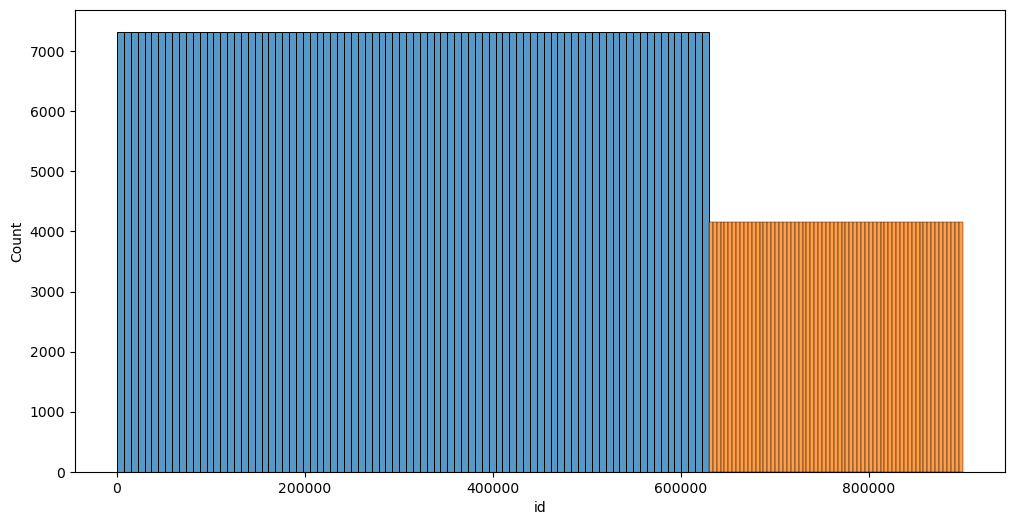

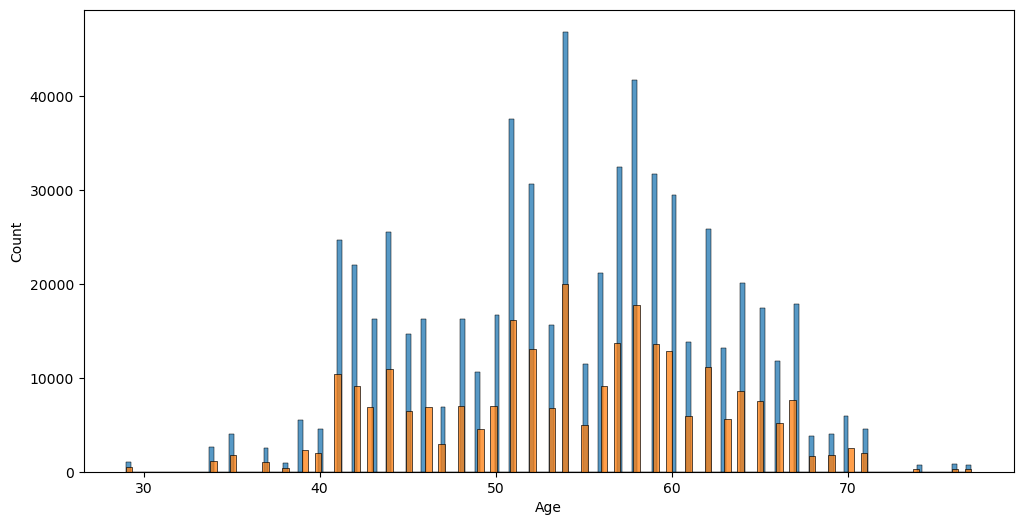

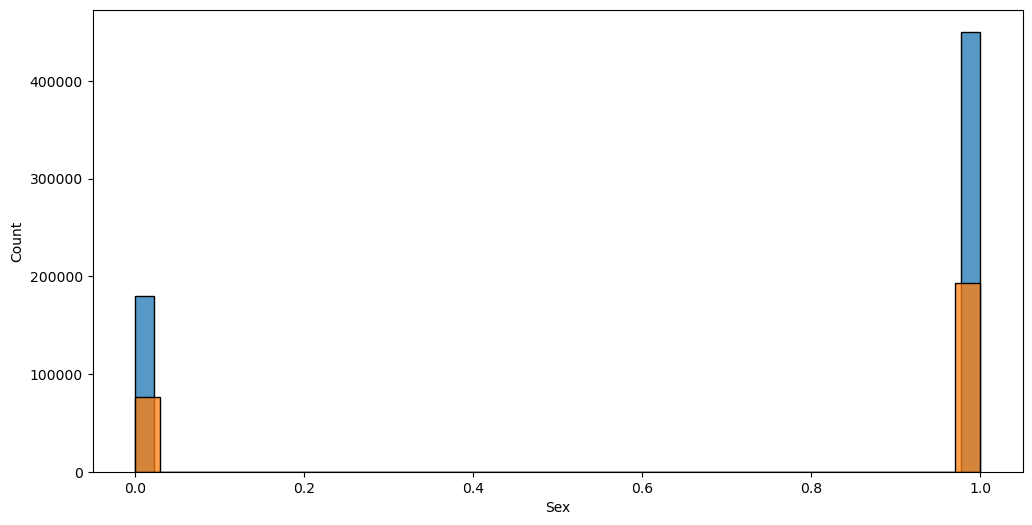

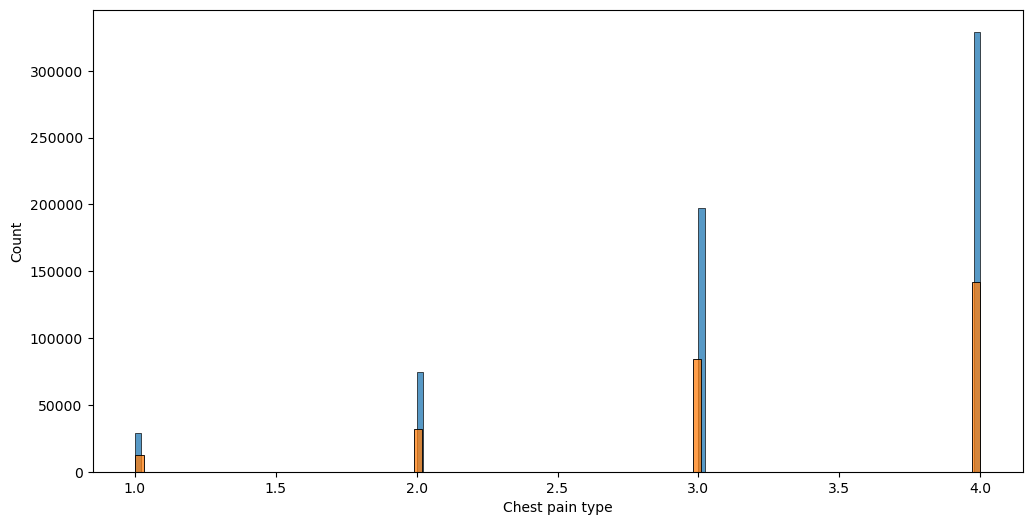

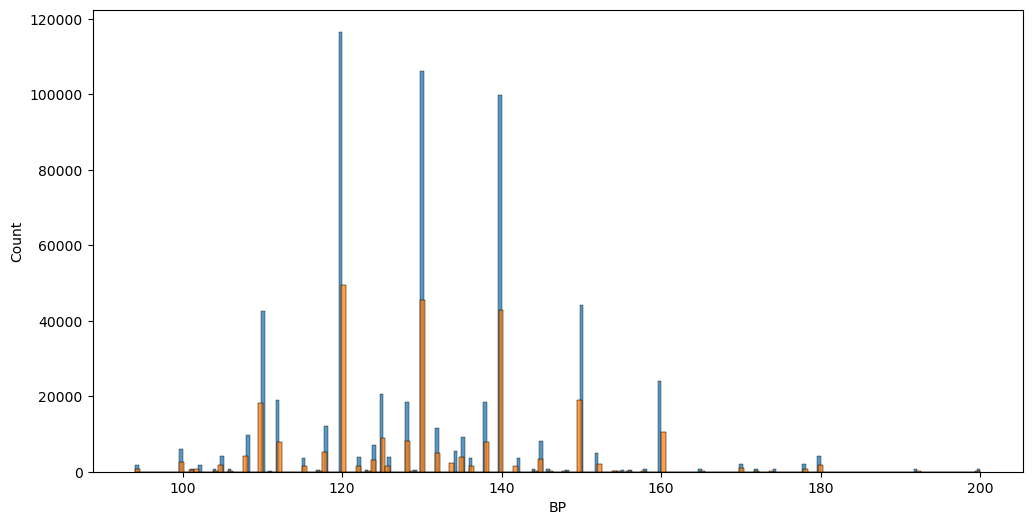

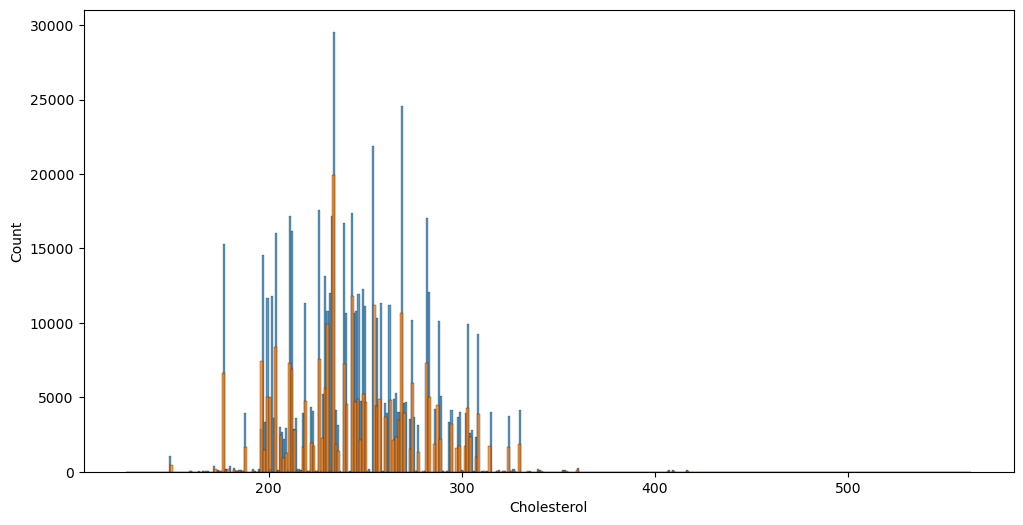

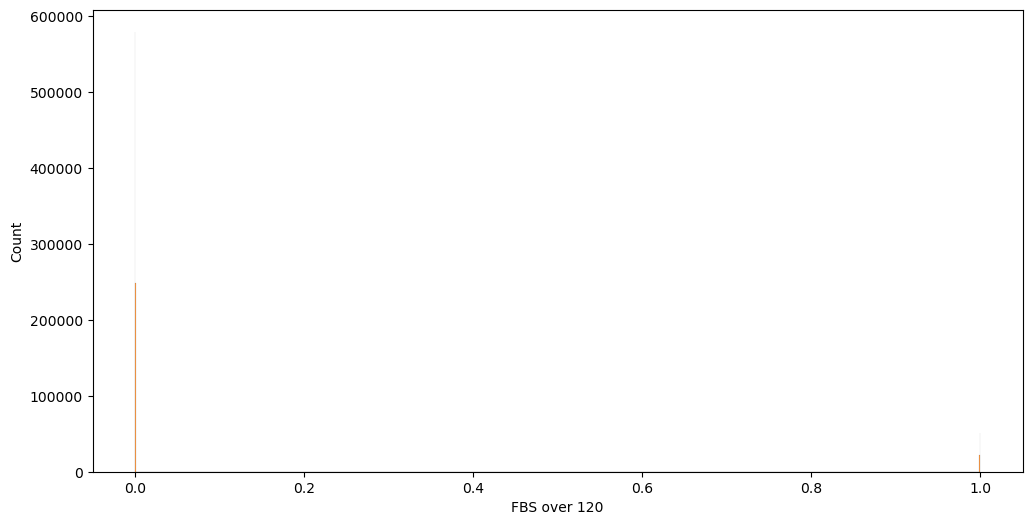

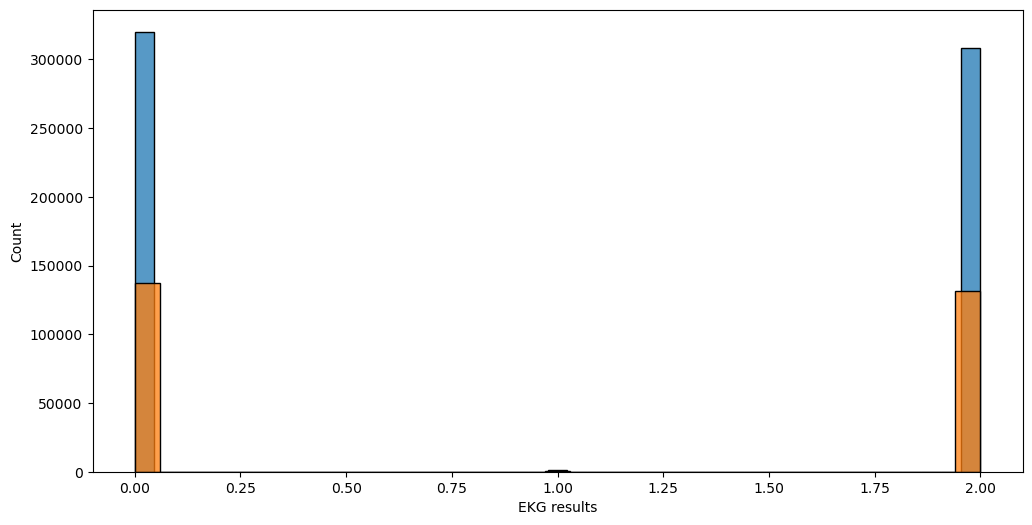

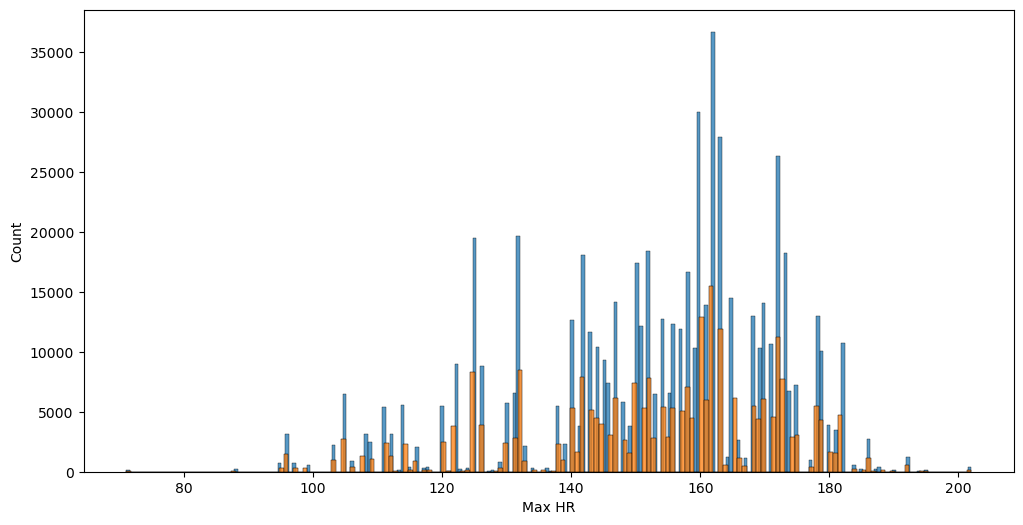

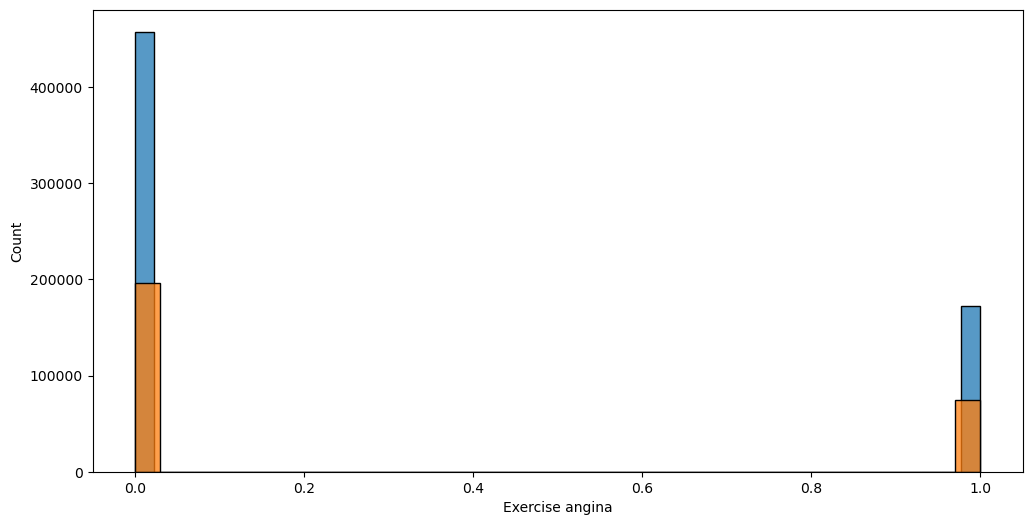

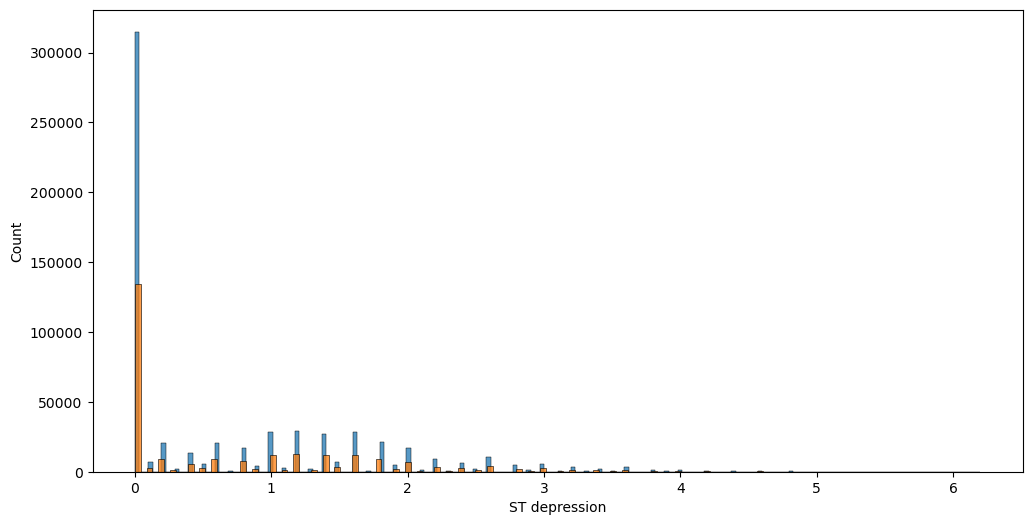

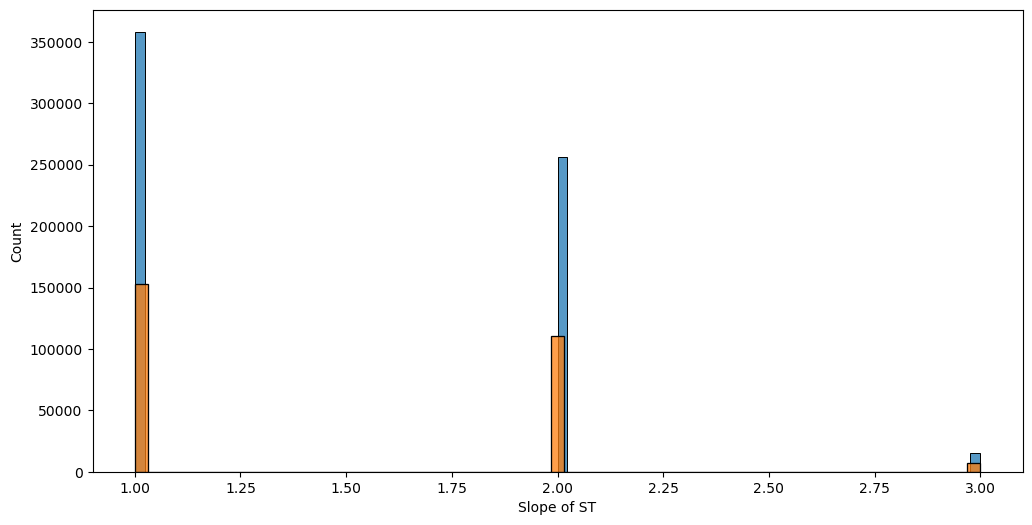

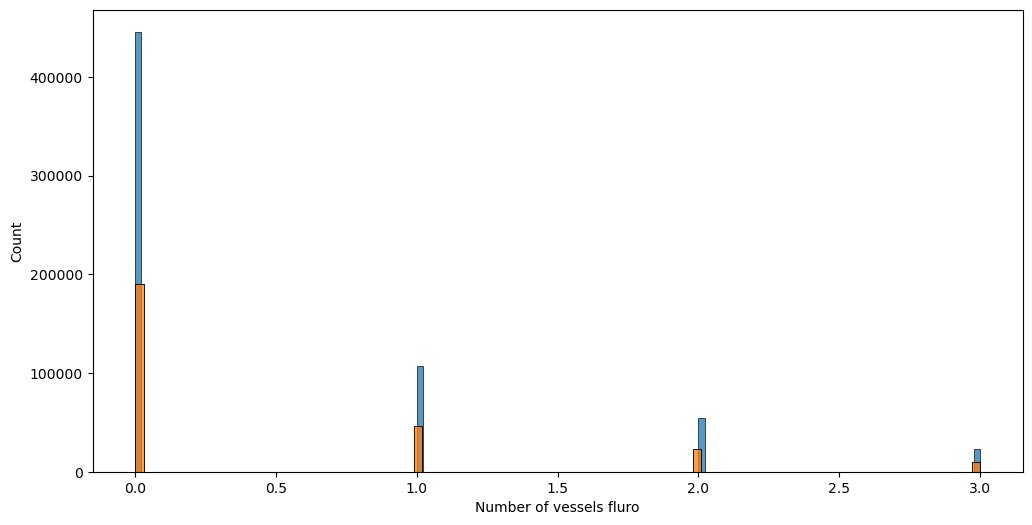

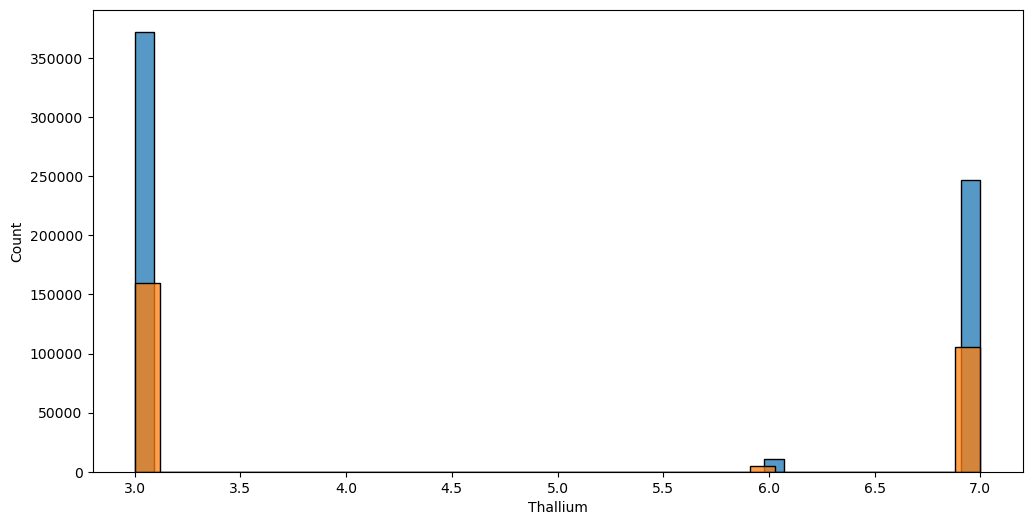

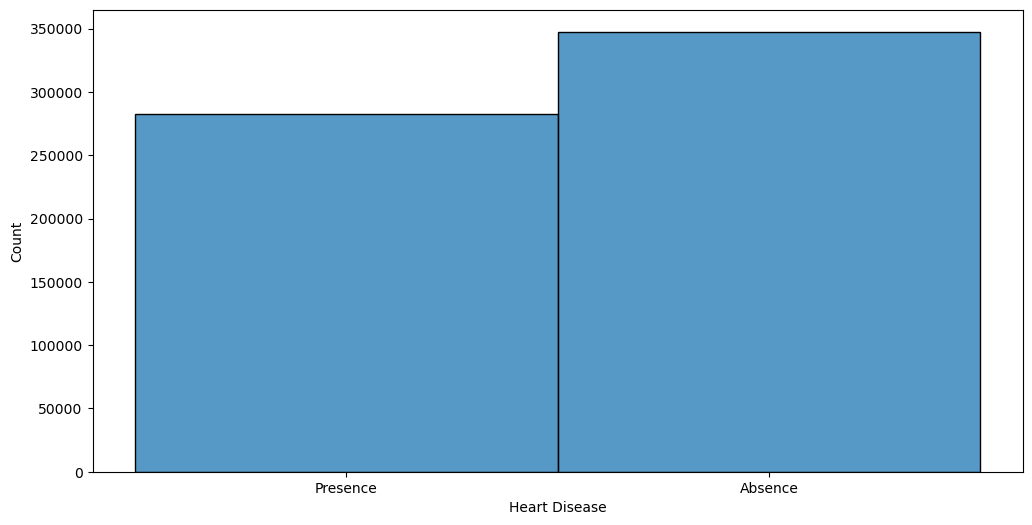

In [18]:
for col in train_df.columns:
    sns.histplot(train_df[col])
    if col in test_df.columns:
        sns.histplot(test_df[col])
    plt.show()

## Frequency Encoding

In [19]:
for col in train_df:
    train_df[f'{col}_freq'] = train_df[col].map(train_df[col].value_counts())

In [20]:
train_df

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease,id_freq,Age_freq,Sex_freq,Chest pain type_freq,BP_freq,Cholesterol_freq,FBS over 120_freq,EKG results_freq,Max HR_freq,Exercise angina_freq,ST depression_freq,Slope of ST_freq,Number of vessels fluro_freq,Thallium_freq,Heart Disease_freq
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence,1,41714,450283,329179,4828,16708,579608,320116,16651,172447,3447,256215,54303,246748,282454
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence,1,30572,450283,28602,20480,3730,579608,308562,10673,457553,314939,358293,445862,372286,347546
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence,1,21149,179717,74941,24133,3928,579608,308562,12114,457553,314939,358293,445862,372286,347546
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence,1,25476,179717,197278,5568,13149,579608,308562,17385,457553,28647,256215,445862,372286,347546
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence,1,41714,450283,329179,99775,29562,579608,308562,19513,172447,1278,256215,22857,372286,282454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,629995,56,0,1,110,226,0,0,132,0,0.0,1,0,7,Absence,1,21149,179717,28602,42639,17562,579608,320116,19643,457553,314939,358293,445862,246748,347546
629996,629996,54,1,4,128,249,1,2,150,0,0.0,2,0,3,Absence,1,46826,450283,329179,18559,12259,50392,308562,17385,457553,314939,256215,445862,372286,347546
629997,629997,67,1,4,130,275,0,0,149,0,0.0,1,2,7,Presence,1,17832,450283,329179,106259,3685,579608,320116,3850,457553,314939,358293,54303,246748,282454
629998,629998,52,1,4,140,199,0,2,157,0,0.0,1,0,6,Presence,1,30572,450283,329179,99775,11652,579608,308562,11874,457553,314939,358293,445862,10966,282454


In [21]:
for col in categorical_features:
      print(f"{col}:\n{train_df[col].value_counts()}\n")

## Bar Charts

## Kmeans

## Scatter Plots

## Correlation Plots

In [22]:
df['heart_disease'].value_counts()

heart_disease
0    347546
1    282454
Name: count, dtype: int64

<Axes: >

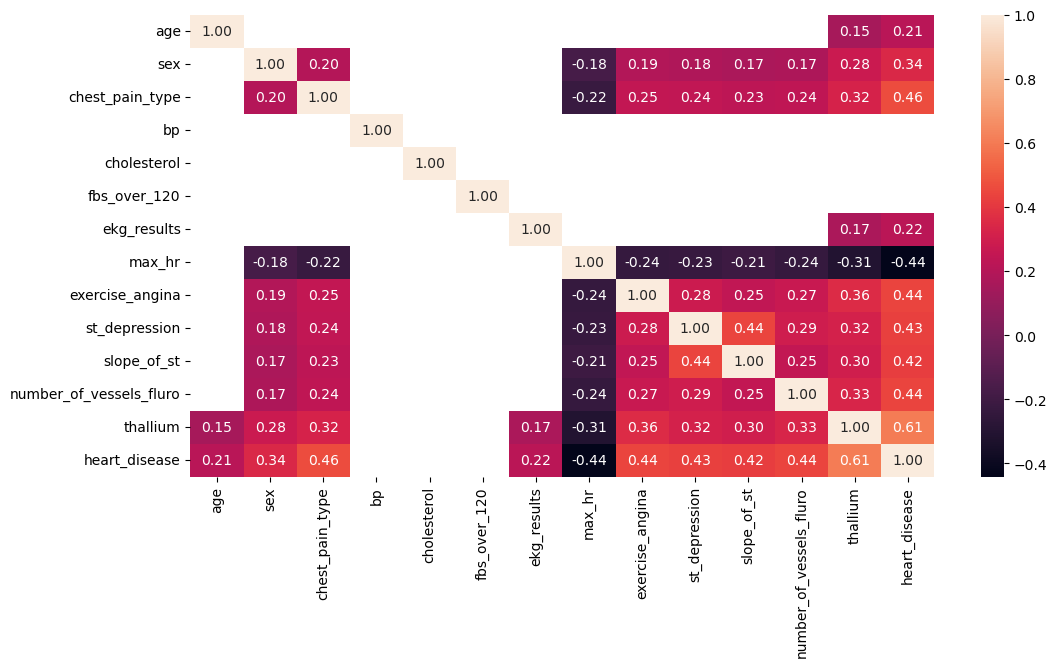

In [23]:
corr_matrix = df.corr(numeric_only=True)

mask = abs(corr_matrix) < 0.15

sns.heatmap(data=corr_matrix, mask=mask, fmt='.2f', annot=True)

## Looking for interactions

In [24]:
corr_matrix[target].sort_values(ascending=False)

heart_disease              1.000000
thallium                   0.605776
chest_pain_type            0.460684
exercise_angina            0.441864
number_of_vessels_fluro    0.438604
st_depression              0.430641
slope_of_st                0.415050
sex                        0.342446
ekg_results                0.218961
age                        0.212091
cholesterol                0.082753
fbs_over_120               0.033570
bp                        -0.005181
max_hr                    -0.440985
Name: heart_disease, dtype: float64

In [25]:
for cat in categorical_features:
    print(df.groupby(cat)['exam_score'].mean().sort_values())

## Compare train vs orig

In [26]:
train_df.describe()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,id_freq,Age_freq,Sex_freq,Chest pain type_freq,BP_freq,Cholesterol_freq,FBS over 120_freq,EKG results_freq,Max HR_freq,Exercise angina_freq,ST depression_freq,Slope of ST_freq,Number of vessels fluro_freq,Thallium_freq,Heart Disease_freq
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.0,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873,1.0,24725.801749,373099.968537,243986.747952,65805.023994,12399.205610,537277.440203,313788.109498,15308.029587,379512.247013,166593.403673,308349.209743,339219.799660,316828.086438,318362.673384
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007,0.0,11675.947893,122171.631065,99904.035314,44766.013930,6939.899838,143562.411359,15446.757624,9030.177068,127120.232239,148469.851617,68066.111825,166840.152374,73276.180948,32371.842813
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.0,1.000000,179717.000000,28602.000000,1.000000,1.000000,50392.000000,1322.000000,1.000000,172447.000000,1.000000,15492.000000,22857.000000,10966.000000,282454.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.0,16246.000000,179717.000000,197278.000000,18905.000000,5233.000000,579608.000000,308562.000000,9300.000000,172447.000000,20474.000000,256215.000000,106978.000000,246748.000000,282454.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000,1.0,24633.000000,450283.000000,329179.000000,99775.000000,11652.000000,579608.000000,320116.000000,13004.000000,457553.000000,29269.000000,358293.000000,445862.000000,372286.000000,347546.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000,1.0,32442.000000,450283.000000,329179.000000,106259.000000,17016.000000,579608.000000,320116.000000,19513.000000,457553.000000,314939.000000,358293.000000,445862.000000,372286.000000,347546.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.0,46826.000000,450283.000000,329179.000000,116574.000000,29562.000000,579608.000000,320116.000000,36703.000000,457553.000000,314939.000000,358293.000000,445862.000000,372286.000000,347546.000000
